In [251]:
import sys
sys.path.append("../../")

from HedgeHog import ols_hedge_ratio, hedge_hog, dv01_neutral_steepener_hegde_ratio, dv01_neutral_butterfly_hegde_ratio
from CurveDataFetcher import CurveDataFetcher 
from CurveBuilder import calc_ust_metrics, calc_ust_impl_spot_n_fwd_curve
from CurveInterpolator import GeneralCurveInterpolator
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from typing import Optional, Dict

from utils.pca import run_pca_yield_curve, create_residuals_surface_plot, plot_residuals_for_date
from utils.viz import plot_usts, plot_timeseries, run_basic_linear_regression_df

import scipy
import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../../.env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (20, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2


cluster_date_ranges = [
    (datetime(2023, 2, 10), datetime(2023, 3, 10), "blue", "Cluster 0"),
    (datetime(2023, 5, 18), datetime(2023, 7, 31), "blue", "Cluster 0"),
    
    (datetime(2023, 9, 15), datetime(2023, 11, 27), "red", "Cluster 1"),
    (datetime(2024, 4, 10), datetime(2024, 5, 31), "red", "Cluster 1"),
    
    (datetime(2023, 7, 27), datetime(2023, 9, 14), "green", "Cluster 2"),
    (datetime(2023, 11, 28), datetime(2023, 12, 12), "green", "Cluster 2"),
    (datetime(2024, 1, 17), datetime(2024, 4, 9), "green", "Cluster 2"),
    (datetime(2024, 6, 3), datetime(2024, 7, 20), "green", "Cluster 2"),
    
    (datetime(2023, 1, 3), datetime(2023, 2, 9), "purple", "Cluster 3"),
    (datetime(2023, 3, 13), datetime(2023, 5, 17), "purple", "Cluster 3"),
    (datetime(2023, 12, 12), datetime(2024, 1, 17), "purple", "Cluster 3"),
    (datetime(2024, 7, 22), datetime(2024, 8, 5), "purple", "Cluster 3"),
    
    (datetime(2024, 8, 6), datetime(2024, 9, 30), "orange", "Cluster 4"),
]

c:\Users\chris\Curvy-CUSIPs\notebooks\PCA\../../.env
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Principal Components Analysis (PCA) applied to US Treasuries (USTs) - A Visualization Approach

## Background:

PCA applied on the interest rate term structure is not a novel idea and is required reading for any first-year analyst on a rates desk. Where I want to focus this report is building an intuitive and geometric understanding of PCA applied to the US Treasury Market through interative visualization powered by [Plotly](https://plotly.com/).

I will provide shallow background needed to grasp how traders can apply PCA to USTs as a tool to set up/screen for Relative Value (RV) and also derive hedge ratios for curves and flies.

For a deeper understanding of Fixed Income, I point you to [Tuckman](https://shamit8.wordpress.com/wp-content/uploads/2014/11/fixed-income-securities-bruce-tuckman2002-2ndedition.pdf). For a better mathematical treatment of PCA (at the undergrad level), I point you to [Strang](https://math.mit.edu/~gs/linearalgebra/ila5/indexila5.html) or [ESL](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf).

Much of this report was motivated by concepts explained in [Credit Suisse's **PCA Unleashed**](https://github.com/cleeclee123/Curvy-CUSIPs/blob/main/research/PCA/PCA%20Unleashed.%20Interest%20Rate%20Strategy.%20Spot%201y%201y1y%202y1y%203y1y%204y1y%205y1y%206y1y%207y1y%208y1y%209y1y%2010y2y%2012y3y%2015y5y%2020y5y%2025y5y%2030y10y%2040y10y.pdf) and [Salomon Smith Barney's **Principles of Principal Components**](https://github.com/cleeclee123/Curvy-CUSIPs/blob/main/research/PCA/_Salomon_Smith_Barney__Principles_of_Principal_Components___A_Fresh_Look_at_Risk__Hedging_and_Relati.pdf)

Side Note: Here's the best [video](https://youtu.be/nEvKduLXFvk?si=BTcTOokY2P6DX0OM) on the internet for building a general intuition of PCA

### What's PCA?

**First, let's ask the question, what the heck are we doing?**

We want to take high-dimensional data i.e. something with many columns (like the term structure of interest rates) and boil it down to something more digestible without losing too much information along the way - no free lunch! This will allow us to analyze how the entire term structure of interest rates moves with respect to time, relative to specific tenors, and what has been the most important ***factors*** or **principal components** shaping the yield curve. This lead us to intuitive interpretations for our PCs on the UST term structure. 

- PC1: Level Component => the entire curve shifts up, a parallel move
- PC2: Slope Component => 2s10s rallies, steepening/flattening moves
- PC3: Curvature Component => 2s5s10s rallies, concave/convex moves in the yield curve
- PC4, PC5, ... who knows?

We emphaize that we are revealing the mechanisms of the term structure under the form of uncorrelated linear factors with PCA. Each PC is chosen to have the maximum possible
variance given all earlier PCs. The first PC explains the largest fraction of the sum of the variances of the rates; the second PC explains the next largest fraction; and so forth. The sum of the variances of the first three PCs is usually an overwhelming fraction of the sum of the variances across the term structure (95%+)

A little bit of math...

We start with the covariance matrix of the term structure rather than the correlation matrix since we do not want standardization between two entries but keeping the volatility observed from the entire term structure. We then construct the orthonormal basis of the eigenvectors of the covariance matrix. This is geometrically intuitive since PCs are uncorrelated relationships. The factors capturing level, slope, and curvature moves are the eigenvectors and their relative strength to the (scaled) eigenvalues. So the greatest absolute eigenvalue points to the direction of the highest variation (most important structural relationship captured in the term structure => PC1) making its corresponding eigenvector longest (which we will visualize below).

All of this will allow us:
- Get a broad sense of how the yield curve has moved over time
- Conduct rich or cheap analysis based on maturity or even specifc CUSIPs
- Allow for superior hedge ratios for curve and fly trades

### Quick Note on Implementation:
- An implicit assumption in PCA is that the data are independent and identically distributed meaning that the time series aspect of our input data is not recognized in PCA. Therefore, this assumption would be violated if we were doing PCA on yield changes, and the changes depended on the yield levels (this is debated topic that we leave for another time). Most of uur analysis below will be run on yield levels but we will note when we decided to use changes in yields.
- We will be ignoring higher-order PCs given the fact that the first three PCs explain more than 99% of the variance in the term structure
- There are many different strategies that can be applied to the input data: rolling windows, excluding certain dates (SVB, repo blow up, etc), using bid vs offer vs mid vs EOD yields on OTR USTs - we will save much of this discussion for another time and run our PCA on CMT yields and EOD markings on specifc CUSIPs from FedInvest.
- Srini Ramaswamy from JP Morgan's US Rates Strategy has written about [i-PCA: Implied Principal Component Analysis](https://github.com/cleeclee123/Curvy-CUSIPs/blob/main/research/PCA/Interest%20Rate%20Derivatives%20i-PCA%20Implied%20Principal%20Component%20Analysis.%20Tue%20Dec%2006%202022.pdf) where one can use implied correlations derived from Yield Curve Spread Options (YSCO) IVs to get forward-looking hedge ratios versus using the ***ex-post*** realized betas, (backward looking) hedge ratios. 
- Much of this analysis was conducted with [Curvy-CUSIPs](https://github.com/cleeclee123/Curvy-CUSIPs) - a Python package (still in development) by me that abstracts the data fetching logic, the math, and the visualization work needed to conduct institutional-level fixed income analysis

### Quick Note on Eigenvalue (In)Stability over Time:
- Using historical data is by definition backwards-looking. We know relationships change - i.e. if the eigenvectors of said covarience matrix change after entering into a trade with backwards-looking hedge ratios computed with PCA (or regression, DV01 neutral, etc), we will become exposed to unintended factor risk. Say for example, a change of the first eigenvector results in the hedge breaking down and in directional exposure for a fly we put on - THIS IS A BIG PROBLEM. We can investigate and point to many reason for the ***cause*** of this deterioration, quoting Schaller and Huggins, "the problem is the same as in the case of correlation between factors occurring after entering into a PCA-neutral position: it loses its neutrality and becomes exposed to factors it was not intended to."
- A quick fix for perceived instability is to just pick a longer timeframe of data to run PCA
- Distinguishing the differences in level vol -> factor vol and factor loadings vol

## Visualization 1: The Basics, Term Structure over Time, BiPlot:

### Data:

We will be using CMT (Constant Maturity Treasury) rates from early 2020 to Q3 2024 sourced from FRED.. see below

In [25]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])
cmt_yields_df = curve_data_fetcher.fred_data_fetcher.get_historical_cmt_yields(start_date=datetime(2023, 1, 1), end_date=datetime(2024, 9, 30))
cmt_yields_df = cmt_yields_df.dropna()

cmt_spreads_df = cmt_yields_df.copy()
cmt_spreads_df["2s5s"] = cmt_spreads_df["CMT5"] - cmt_spreads_df["CMT2"]
cmt_spreads_df["2s10s"] = cmt_spreads_df["CMT10"] - cmt_spreads_df["CMT2"]
cmt_spreads_df["5s30s"] = cmt_spreads_df["CMT30"] - cmt_spreads_df["CMT5"]
cmt_spreads_df["2s5s10s"] = (cmt_spreads_df["CMT5"] - cmt_spreads_df["CMT2"]) - (cmt_spreads_df["CMT10"] - cmt_spreads_df["CMT5"])
cmt_spreads_df["2s10s30s"] = (cmt_spreads_df["CMT10"] - cmt_spreads_df["CMT2"]) - (cmt_spreads_df["CMT30"] - cmt_spreads_df["CMT10"])

cmt_yields_df

Fetching from FRED...


,Date,CMT3M,CMT6M,CMT1,CMT2,CMT3,CMT5,CMT7,CMT10,CMT20,CMT30
0,2023-01-03,4.40,4.63,4.72,4.40,4.18,3.94,3.89,3.79,4.06,3.88
1,2023-01-04,4.41,4.64,4.71,4.36,4.11,3.85,3.79,3.69,3.97,3.81
2,2023-01-05,4.51,4.68,4.78,4.45,4.18,3.90,3.82,3.71,3.96,3.78
3,2023-01-06,4.51,4.65,4.71,4.24,3.96,3.69,3.63,3.55,3.84,3.67
4,2023-01-09,4.55,4.69,4.69,4.19,3.93,3.66,3.60,3.53,3.83,3.66
...,...,...,...,...,...,...,...,...,...,...,...
433,2024-09-24,4.50,4.23,3.88,3.49,3.44,3.47,3.60,3.74,4.13,4.09
434,2024-09-25,4.51,4.24,3.89,3.53,3.49,3.52,3.65,3.79,4.18,4.14
435,2024-09-26,4.50,4.26,3.96,3.60,3.54,3.55,3.65,3.79,4.17,4.12
436,2024-09-27,4.50,4.24,3.90,3.55,3.49,3.50,3.60,3.75,4.15,4.10


### The Basics:

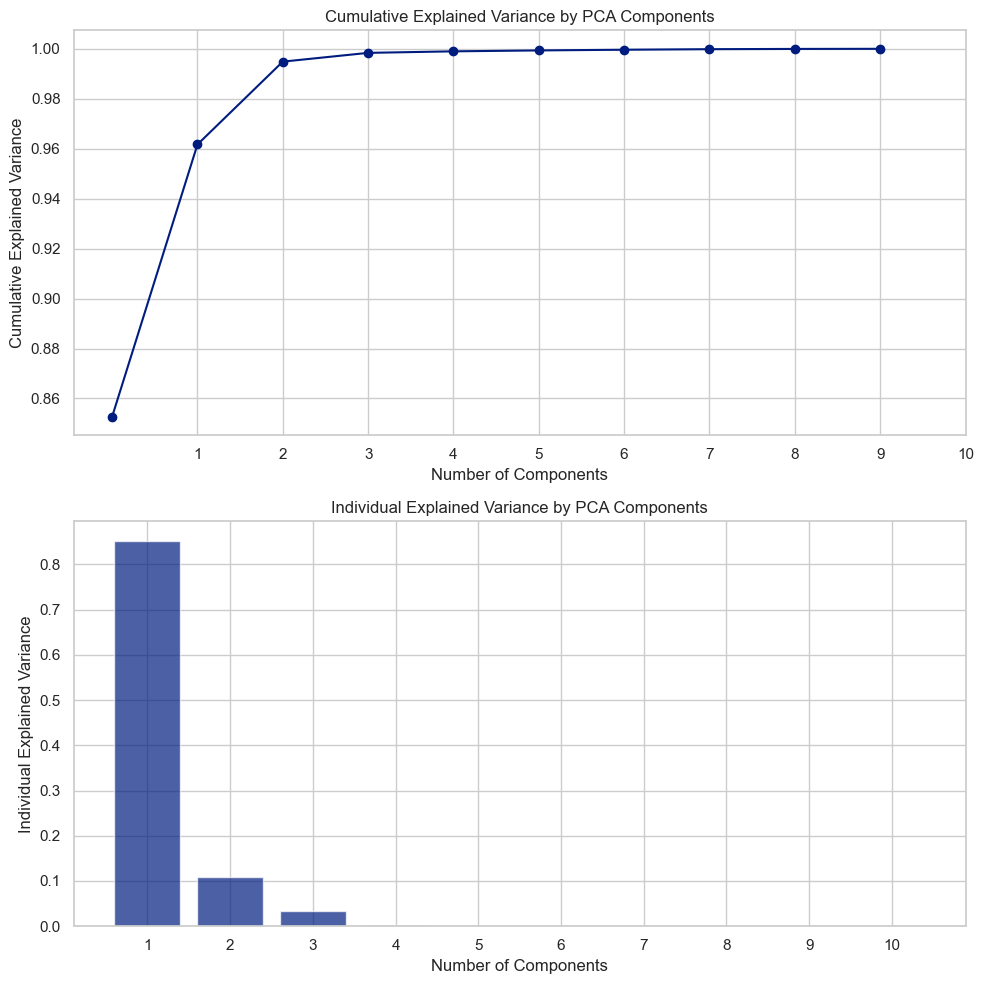

In [49]:
pca = run_pca_yield_curve(
    df=cmt_yields_df.set_index("Date"),
    n_components=3,
    show_cumul_ex_var=True,
)

As we mentioned multiple times above, we see that the majority of the varience explained in the term structure is contained in the first 3 PCs.

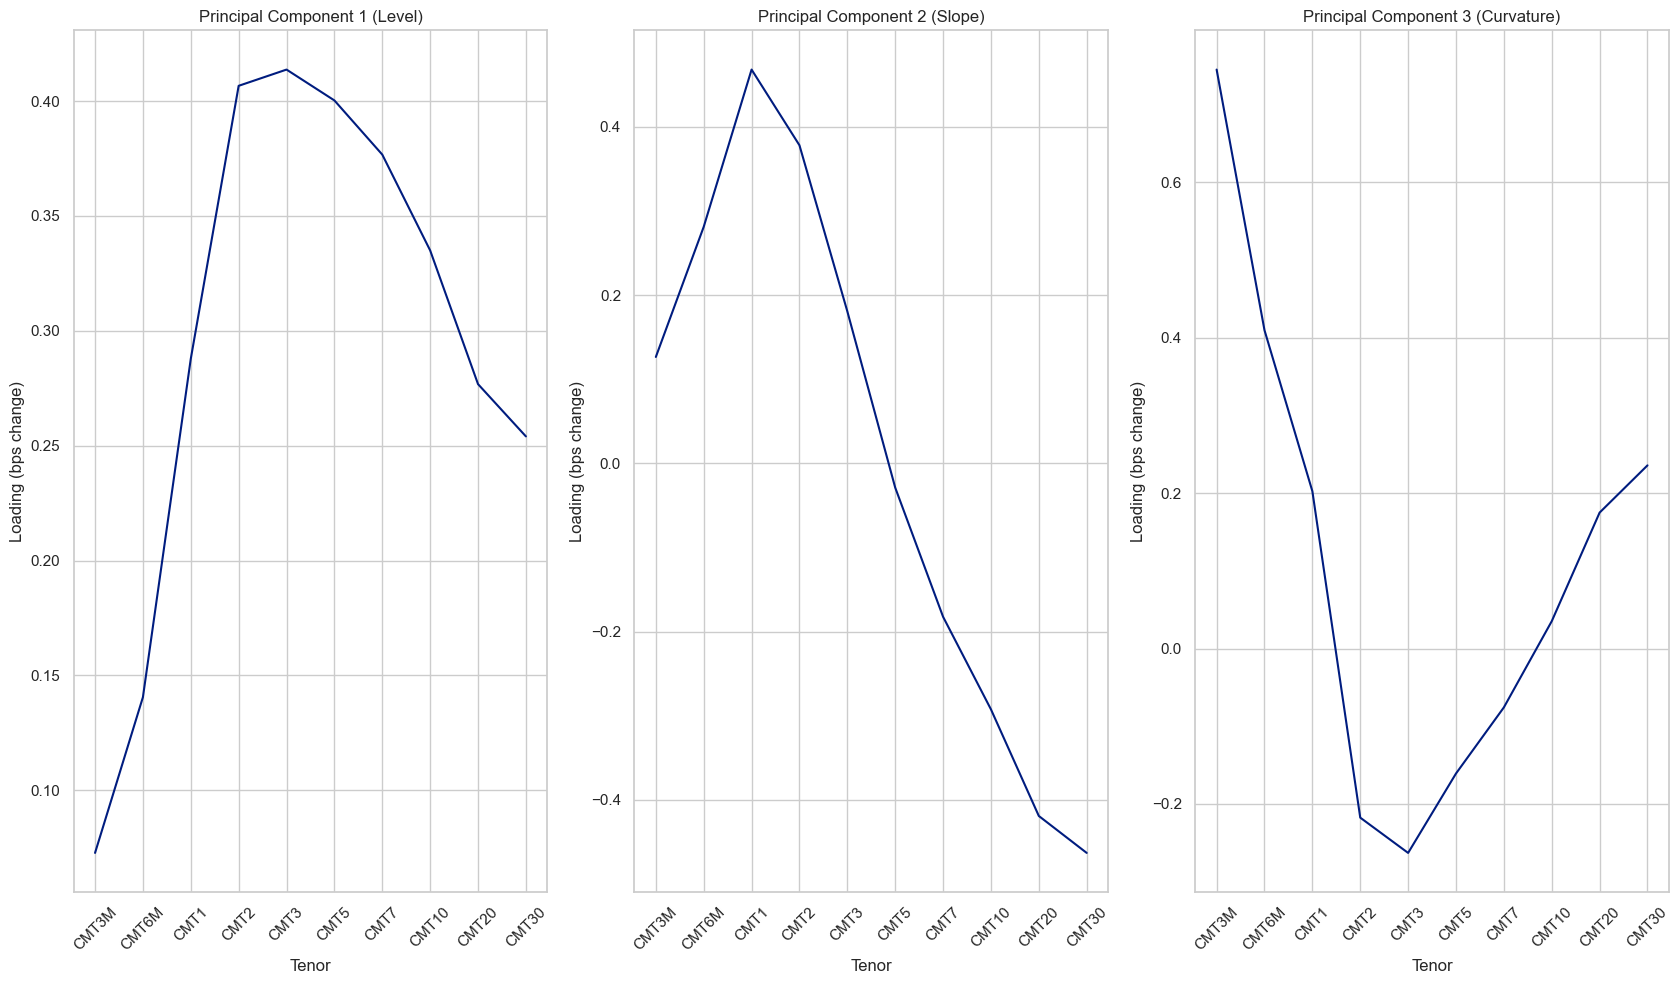

In [48]:
pc3 = run_pca_yield_curve(
    df=cmt_yields_df.set_index("Date"),
    n_components=3,
    show_eigenvectors=True,
    run_on_diff=True
)

We ran PCA on daily yield changes to give a better interpretation of the chart above - where the PCs are built as a linear combination of all tenors. Much of the interpretation of this chart was inspired from [Credit Suisse's **PCA Unleashed**](https://github.com/cleeclee123/Curvy-CUSIPs/blob/main/research/PCA/PCA%20Unleashed.%20Interest%20Rate%20Strategy.%20Spot%201y%201y1y%202y1y%203y1y%204y1y%205y1y%206y1y%207y1y%208y1y%209y1y%2010y2y%2012y3y%2015y5y%2020y5y%2025y5y%2030y10y%2040y10y.pdf)


- The first component has positive coefficients for all the variables: it can be seen as a proxy for the level of yields and explains most of the dispersion. 
- The second one has positive factors for the short-end that increases until the global max at CMT1 and then starts a steep decent at the belly which then becomes negative at  CMT5 and increasingly negative at the long-end of the curve. It represents the slope of the swap curve: the short-end is anti-correlated to the long-end from this angle. Paired with what we saw in PC1, this gives evidence of the systematic nature of the yield curve to steepen when the short rate comes down.
- The third component has positive coefficients for the short- and long-ends, while it has negative coefficients in the belly of the curve. This indicates that the axis
distinguishes the relative impact on a point from a curvature effect. Again, this provides evidence for the systematic nature of the yield curve to steepen when the short rate comes down. Furthermore, we can describe steepening more precisely as "normalization" where the front end steepens more relative to the long end - perhaps even flattening out - resulting in the "textbook" yield curve shape, increasing the hump in the intermediate sector of the curve

We can see that the that the change in yields (PC1) is greatest for short maturities and the belly (CMT2-CMT7) and smallest for the very front end and longer maturities. Therefore, the short-end/belly of the curve steepens and the long-end flattens or more precisely, we see traders buying/receiving the belly in a fly - contributing to a more convex yield curve. This makes sense under the current macro environment (09/30/2024) - given the fact that the Fed has only recently cut, anchoring the very short-end from rallying even more and traders piling up in 2s/belly to ride the cutting cycle - in which rate cut expectations have been whipsawed around all this year - leading to the high PC1 levels in CMT2 thru the belly. Moving to the higher-order PCs, a positive realization of PC2 will cause the short-end to grind higher (positive coefficients) and the longer maturities to move lower (negative coefficients) - explaining why bull-steepening (soft NFP, cool CPI) as well as bear-flattening (hot ECO data) still occur in the current environment. 

We verify these relationships visually below:

### The Term Structure over Time:

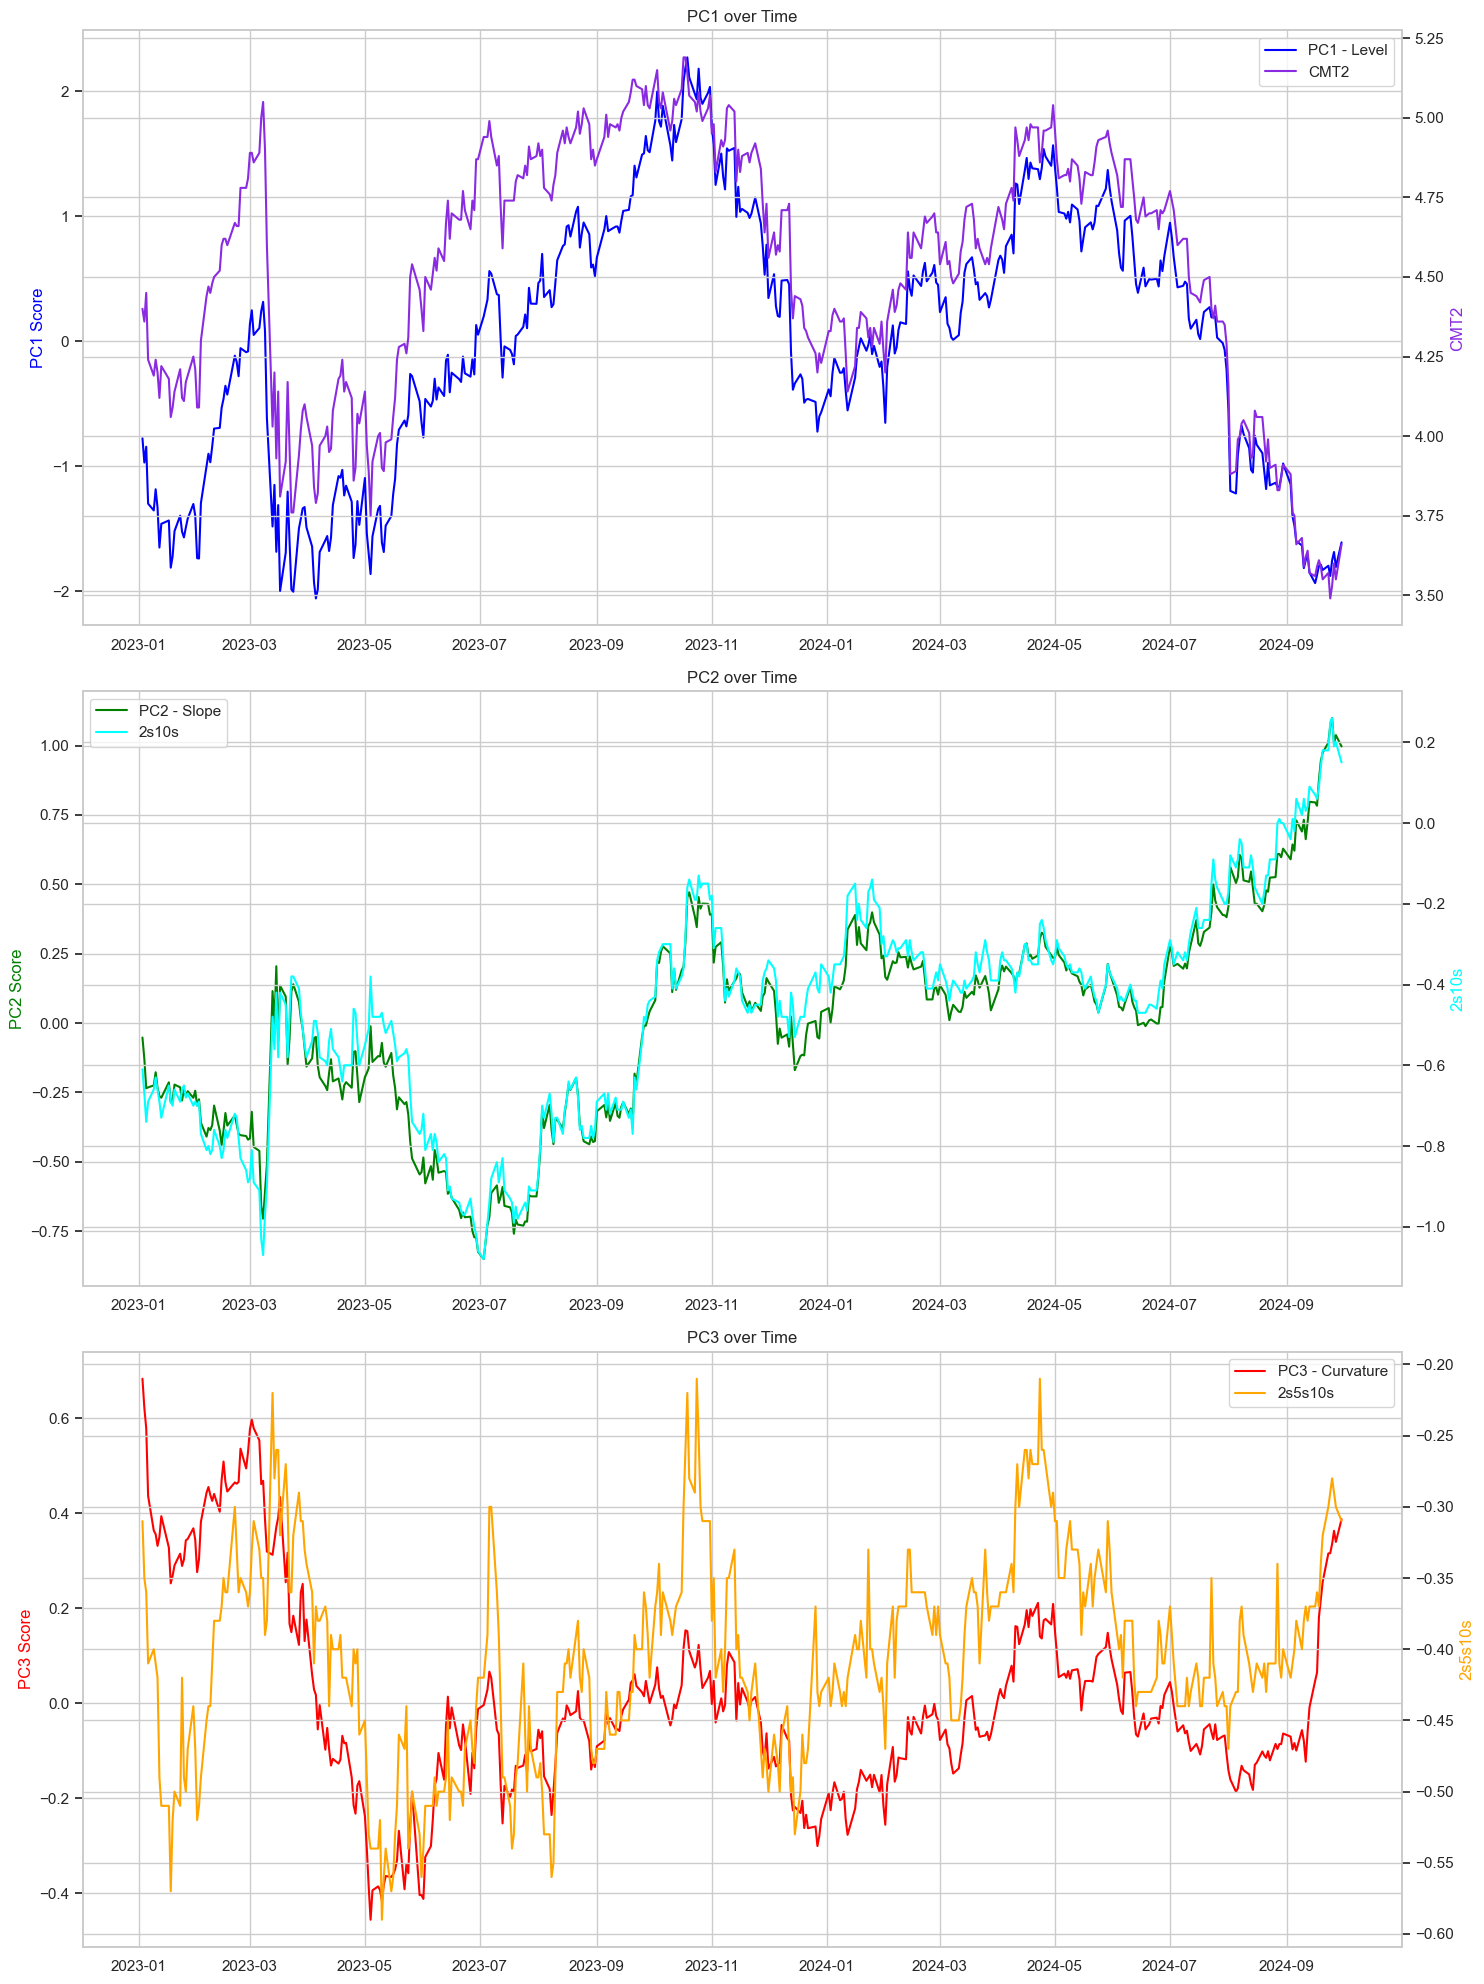

In [47]:
pc3_ct_df = run_pca_yield_curve(
    df=cmt_yields_df.set_index("Date"),
    n_components=3,
    show_pc_scores_timeseries=True,
    overlay_df=cmt_spreads_df.set_index("Date"),
    to_overlay_pcs_v_time_cols=["CMT2", "2s10s", "2s5s10s"]
)

Above are PCs over time with CMT2 overlaid on PC1, 2s10s overlaid on PC2, and 2s5s10s overlaid on PC3. I find that interpreting PCs over time takes a tad bit of overhead. This reasoning is driven by the fact that the units plotted are in e principal components scores - the new coordinate system of reduce dimensionality.

- PC1 captures the general rally we have been seeing in rates this past year - evident by 2s. 
- PC2 captures the steepening of the yield curve as inflation eases and the labor market normalizes, along with rate cut expectations
- PC3 captures the convex shape of the yield curve in recent years - as investors bid up the belly, wanting to position themselves for a fed cutting cycle. However, recently, we start to see the expectation of further yield cuve normalization come in PC3 spiking and traders selling the belly in 2s5s10s.

While nothing ground breaking, PCs over time is a great way of visualizing the ***entire*** term structure over time in limited dimensionality. It's a nice way of wrapping up what we already have been observing - overall bull-steepening. 

Some notable events in our dataset includes: 
  - SVB - March 2023 
  - Final hikes in the current cycle during Summer 2023
  - The everything rally in late 2023
  - Powell's December 2023 Pivot
  - The great rate cut expectation unwind all of early 2024
  - BOJ Hike/Yen Carry/Dispersion Trade Unwind in Late Summer 2024
  - Fed cuts by 50bps in Sep 2024

### The BiPlot:

Specifically, in a 3D PCA biplot, the three axes represent the three PC scores (PC1, PC2, and PC3). As we can guess, each axis captures the variance in the data along that pc, which is a linear combination of the original variables that explains the greatest amount of variance in the dataset. The relative lengths of these axes indicate how much variance each principal component captures. In 3D space, we can notice obvious clusters - a shift in clusters over time can represent a narrative shift in USTs  - something that we will explore below. We also represent the original variables (CMT rates in our case) as vectors or, mathematically, as the eigenvectors of the covariance matrix. By definition, the direction of each vector shows how much a variable influences each PC. A variable that points strongly in the direction of a particular axis (PC1, PC2, or PC3) has a strong influence on that principal component.

Below is an interactive BiPlot of UST CMT Yields from 2023 - Q3 2024 

In [50]:
pc3_ct_df = run_pca_yield_curve(
    df=cmt_yields_df.set_index("Date"),
    is_cmt_df=True,
    n_components=3,
    show_3d_plot=True,
    show_clusters=True,
    num_clusters=5,
)

<style>
red { color: Red }
orange { color: Orange }
blue { color: #4287f5 }
</style>

- <red>Red Vectors</red> represent the short end 
- <orange>Orange Vectors</orange> represent the belly of the curve
- <blue>Blue Vectors</blue> represent the long end

We identified 5 clusters based on the fairly trivial [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) and then applied [k-Means](https://en.wikipedia.org/wiki/K-means_clustering) clustering to our PCs dataset. We also attempt to pair a fundamental interpreation of the clusters below.

#### Below are summary statistics on each of the 5 PC Clusters:
- Descriptions of the PC Clusters are based on the averages of PC1, PC2, amd PC3 in each cluster and their mapped interpretation to how the yield curve moves
- This is a very loose/rough description of the actual moves in the term structure over time, but for sake of our example, we carry on
- For example, on 2024-09-30 PC Loading were [-1.6072, 0.9968, 0.3876] for PC1, PC2, PC3. That means that on this particular day, we can define the main moves in the UST market by the three drivers of the yield curve: a negative realization of PC1, a positive realization of PC2, and a positive realization of PC3. In markets speak, bonds rallied and the curve steepend - but relatively more at the short end compared to the long end

In [55]:
print("Cluster 0 - Bear Flattening, Belly Rallies")
display(pc3_ct_df["biplot_df"][pc3_ct_df["biplot_df"]["cluster"] == 0].describe())
print("Cluster 1 - Bear Steepening, Belly Sells off")
display(pc3_ct_df["biplot_df"][pc3_ct_df["biplot_df"]["cluster"] == 1].describe())
print("Cluster 2 - Yields Grind Higer/Parallel Moves Up, Belly Rallies")
display(pc3_ct_df["biplot_df"][pc3_ct_df["biplot_df"]["cluster"] == 2].describe())
print("Cluster 3 - Bull Flattening, Belly Sells off")
display(pc3_ct_df["biplot_df"][pc3_ct_df["biplot_df"]["cluster"] == 3].describe())
print("Cluster 4 - Bull Steepening/Yield Curve Normalization")
display(pc3_ct_df["biplot_df"][pc3_ct_df["biplot_df"]["cluster"] == 4].describe())

Cluster 0 - Bear Flattening, Belly Rallies


,Date,PC1,PC2,PC3,cluster
count,93,93.000000,93.000000,93.000000,93.0
mean,2023-08-02 20:07:44.516129024,-0.265196,-0.349587,-0.053094,0.0
min,2023-02-10 00:00:00,-0.825842,-0.850463,-0.412277,0.0
25%,2023-05-24 00:00:00,-0.465556,-0.625046,-0.231192,0.0
50%,2023-06-28 00:00:00,-0.278377,-0.425410,-0.166464,0.0
75%,2023-12-20 00:00:00,-0.088403,-0.055529,-0.012289,0.0
max,2024-08-01 00:00:00,0.333431,0.420083,0.579321,0.0
std,NaN,0.276470,0.341286,0.285085,0.0


Cluster 1 - Bear Steepening, Belly Sells off


,Date,PC1,PC2,PC3,cluster
count,90,90.000000,90.000000,90.000000,90.0
mean,2024-01-09 07:28:00,1.384042,0.154353,0.067103,1.0
min,2023-08-21 00:00:00,0.911488,-0.373002,-0.046830,1.0
25%,2023-10-13 18:00:00,1.055005,0.077190,0.014817,1.0
50%,2023-11-14 12:00:00,1.341497,0.182015,0.054281,1.0
75%,2024-04-29 18:00:00,1.567371,0.254792,0.114291,1.0
max,2024-07-01 00:00:00,2.269642,0.471340,0.211317,1.0
std,NaN,0.357595,0.182796,0.065570,0.0


Cluster 2 - Yields Grind Higer/Parallel Moves Up, Belly Rallies


,Date,PC1,PC2,PC3,cluster
count,139,139.000000,139.000000,139.000000,139.0
mean,2024-02-06 08:58:42.302158336,0.452084,0.021635,-0.057768,2.0
min,2023-03-02 00:00:00,-0.116917,-0.699065,-0.235524,2.0
25%,2023-10-21 12:00:00,0.233947,-0.153837,-0.095095,2.0
50%,2024-02-27 00:00:00,0.469729,0.099555,-0.059224,2.0
75%,2024-06-04 12:00:00,0.651237,0.206776,-0.027592,2.0
max,2024-07-30 00:00:00,0.964523,0.499662,0.597163,2.0
std,NaN,0.283017,0.272369,0.080746,0.0


Cluster 3 - Bull Flattening, Belly Sells off


,Date,PC1,PC2,PC3,cluster
count,75,75.000000,75.000000,75.000000,75.0
mean,2023-03-15 10:52:48,-1.438411,-0.162054,0.099430,3.0
min,2023-01-03 00:00:00,-2.055333,-0.409144,-0.456162,3.0
25%,2023-01-30 12:00:00,-1.645085,-0.240675,-0.129259,3.0
50%,2023-03-27 00:00:00,-1.459146,-0.190221,0.176019,3.0
75%,2023-04-20 12:00:00,-1.279733,-0.102531,0.343630,3.0
max,2023-05-17 00:00:00,-0.775512,0.204854,0.683539,3.0
std,NaN,0.296029,0.130105,0.300772,0.0


Cluster 4 - Bull Steepening/Yield Curve Normalization


,Date,PC1,PC2,PC3,cluster
count,41,41.000000,41.000000,41.000000,41.0
mean,2024-08-31 11:07:19.024390144,-1.338033,0.677235,-0.012904,4.0
min,2024-08-02 00:00:00,-1.933070,0.403002,-0.186397,4.0
25%,2024-08-16 00:00:00,-1.751110,0.524173,-0.125182,4.0
50%,2024-08-30 00:00:00,-1.195866,0.609352,-0.086200,4.0
75%,2024-09-16 00:00:00,-1.028007,0.795389,0.047214,4.0
max,2024-09-30 00:00:00,-0.675252,1.099194,0.387569,4.0
std,NaN,0.403182,0.202261,0.179004,0.0


Below are interactive charts of a subset of CMT yields, spreads, flies, the VIX, and the MOVE Index. We highlighted the  rough date ranges of each PC Cluster in each chart. These charts confirm our ***loose*** interpretation of the PC Clusters above.

In [11]:
plot_timeseries(
    cmt_yields_df,
    y_cols=["CMT2", "CMT5", "CMT10", "CMT30"],
    custom_title="CMT2, CMT5, CMT10, CMT30 - PCs Clusters Highlighted",
    dt_range_highlights=cluster_date_ranges
)

In [18]:
plot_timeseries(
    cmt_yields_df,
    y_cols=["2s10s", "5s30s", "2s5s10s",  "2s10s30s"],
    custom_title="2s10s, 5s30s (lhs) & 2s5s10s, 2s10s30s (rhs) - PCs Clusters Highlighted",
    secondary_y_cols=["2s5s10s", "2s10s30s"],
    dt_range_highlights=cluster_date_ranges,
)

In [14]:
plot_timeseries(
    vol_index_df,
    y_cols=["MOVE", "VIX"],
    custom_title="MOVE Index (lhs) & VIX Index (rhs) - PCs Clusters Highlighted",
    ohlc=True,
    secondary_y_cols=["VIX"],
    dt_range_highlights=cluster_date_ranges,
)

Above, we show how PCA can be used to describe movements in the term structure - we will continue the discussion on the applications of PCA to USTs by showing how traders can derive superior hedge ratios.

## Visualization 2: Hedge Ratios 

Before we dive into the application of PCA to derive hedge ratios, let's spend some time talking about hedge ratios and why its important. Much of the material/concepts below are adapted from the Chapter 5 appendix to Galen Burghardt & Terry Belton's ***The Treasury Bond Basis*** 

Intuitively, a term structure can broadly move in three different ways: a parallel shift up/down, a steepening/flattening, and a twist (more concavity/convexity). Traders can express a view on the term structure with a linear combination of its components. Determining the weights of each of the components is what we will explore below. See that it's important to have the 'correct' hedge ratio b/c its unwise to be exposed to directionality when all you wanted was a curve view. We will show the approaches to calculating hedge ratios for yield curve trades and mention their variations.

### Data:
We will be using YTD CT Yields based on FedInvest's EOD Markings - See Below

In [4]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(start_date=datetime(2024, 1, 1), end_date=datetime(2024, 9, 30)) 
ct_yields_df

,Date,CT2M,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
0,2024-01-02,NaN,5.414579,5.266761,4.812030,4.332596,4.100865,3.930802,3.951168,3.943937,4.247731,4.083212
1,2024-01-03,NaN,5.403556,5.277076,4.822615,4.332576,4.077939,3.895921,3.914869,3.906323,4.209600,4.052949
2,2024-01-04,NaN,5.403156,5.250537,4.855018,4.382398,4.145585,3.972914,3.992895,3.988823,4.295010,4.137418
3,2024-01-05,NaN,5.391337,5.238747,4.854037,4.399235,4.178916,4.015292,4.040103,4.048999,4.363246,4.207898
4,2024-01-08,NaN,5.390940,5.227726,4.831904,4.365890,4.121773,3.966166,3.993101,4.010992,4.322075,4.176737
...,...,...,...,...,...,...,...,...,...,...,...,...
184,2024-09-24,NaN,4.624675,4.395200,3.911596,3.545554,3.441419,3.471390,3.595417,3.733345,4.129349,4.089326
185,2024-09-25,NaN,4.624384,4.394931,3.922212,3.578928,3.486142,3.519812,3.641378,3.782589,4.180605,4.136016
186,2024-09-26,NaN,4.657279,4.391056,3.993103,3.646125,3.542279,3.547492,3.656672,3.786340,4.175915,4.123370
187,2024-09-27,NaN,4.640196,4.365766,3.948073,3.577578,3.486356,3.491648,3.610363,3.748261,4.147890,4.098191


AGGREGATING CURVE SET DFs: 100%|██████████| 4/4 [00:00<00:00, 183.27it/s]


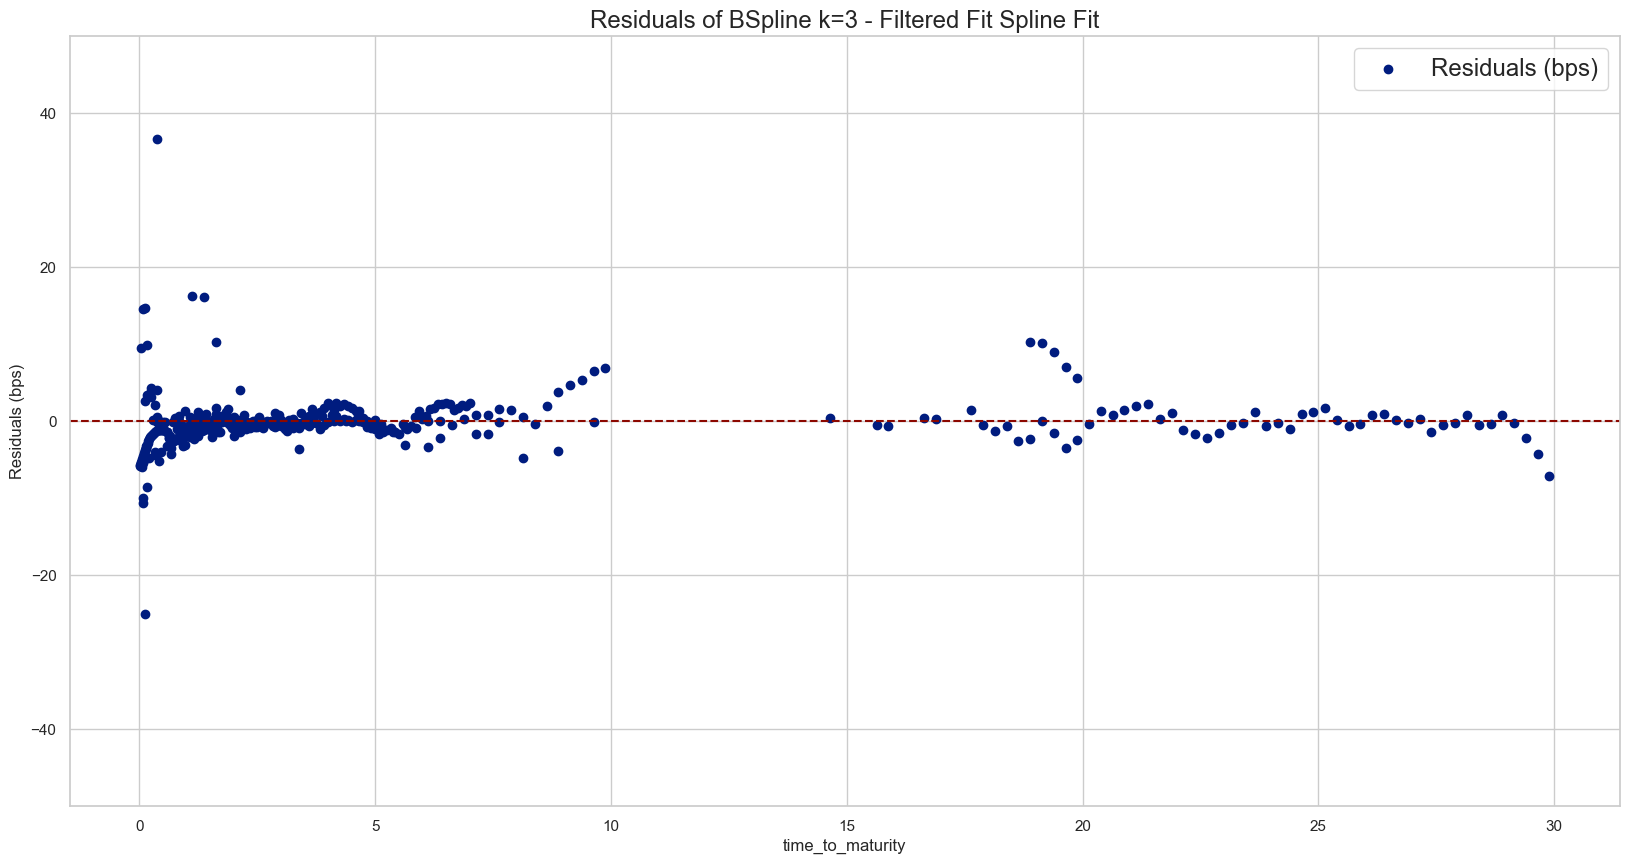

,cusip,security_type,auction_date,issue_date,maturity_date,price_per100,allocation_pctage,avg_med_yield,bid_to_cover_ratio,comp_accepted,...,percentOutstanding,est_outstanding_amt,corpus_cusip_right,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,time_to_maturity,rank,free_float
4,912796K32,Bill,2021-06-24,2021-06-29,2021-08-24,99.992222,7.950000,null,3.600000,39812642500,...,NaN,0.000000e+00,None,NaN,NaN,0.0,NaN,0.150685,0,0.000000e+00
7,912796J26,Bill,2021-06-17,2021-06-22,2021-07-20,99.9965,14.030000,null,3.480000,38759566500,...,0.035684,1.503650e+14,None,NaN,NaN,0.0,NaN,0.054795,0,1.503597e+08
27,912796J75,Bill,2021-06-21,2021-06-24,2021-12-23,99.972194,16.180000,null,3.640000,53477670000,...,NaN,0.000000e+00,None,NaN,NaN,0.0,NaN,0.482192,0,0.000000e+00
40,912796J42,Bill,2021-06-15,2021-06-17,2022-06-16,99.929222,27.580000,null,3.190000,33782782000,...,0.089237,3.733140e+13,None,NaN,NaN,0.0,NaN,0.961644,0,3.732807e+07
65,91282CCK5,Note,2021-06-22,2021-06-30,2023-06-30,99.75277,22.550000,0.219000,2.540000,59890423500,...,NaN,0.000000e+00,None,NaN,NaN,0.0,NaN,2.000000,0,0.000000e+00
100,91282CCG4,Note,2021-06-08,2021-06-15,2024-06-15,99.776274,33.860000,0.295000,2.470000,57961361600,...,0.084193,6.333211e+13,None,NaN,NaN,0.0,NaN,2.961644,0,6.332677e+07
157,91282CCJ8,Note,2021-06-23,2021-06-30,2026-06-30,99.85854,15.140000,0.843000,2.360000,60967054400,...,NaN,0.000000e+00,None,NaN,NaN,0.0,NaN,5.002740,0,0.000000e+00
242,91282CCH2,Note,2021-06-24,2021-06-30,2028-06-30,99.906493,43.090000,1.210000,2.360000,61982078000,...,NaN,0.000000e+00,None,NaN,NaN,0.0,NaN,7.005479,0,0.000000e+00
282,91282CCB5,Note,2021-06-09,2021-06-15,2031-05-15,101.174616,5.890000,1.440000,2.580000,37989945700,...,0.242159,1.042462e+14,912821MH5,62752768.7,62752768.7,0.0,0.0,9.879452,0,1.042210e+08
287,912810SY5,Bond,2021-06-15,2021-06-30,2041-05-15,102.097342,35.870000,2.050000,2.400000,23996113900,...,0.162550,3.224048e+13,None,NaN,NaN,0.0,NaN,19.887671,0,3.223524e+07


In [229]:
date = datetime(2021, 6, 30)
curve_set_df = curve_data_fetcher.fetch_historical_curve_sets(start_date=date, end_date=date, calc_free_float=True, sorted_curve_set=True)[date]

def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]
    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])
    return curve_set_filtered_df

filtered_curveset_df = liquidity_premium_curve_set_filter(curve_set_df)
filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=filtered_curveset_df["time_to_maturity"].to_numpy(),
    y=filtered_curveset_df[f"eod_yield"].to_numpy(),
)
fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[1, 2, 3, 5, 7, 8, 9, 10, 11, 15, 20, 25],
    k=3,
    return_func=True,
)
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"eod_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"eod_price",
        "free_float",
    ],
    zero_curves=[(fitted_bspline, "BSpline k=3 - Filtered Fit")],
)

otr_df: pd.DataFrame = curve_set_df[curve_set_df["rank"] == 0]
otr_df

In [272]:
ct10 = otr_df[otr_df["original_security_term"] == "10-Year"].to_dict("records")[0]
ct5 = otr_df[otr_df["original_security_term"] == "5-Year"].to_dict("records")[0]
ct2 = otr_df[otr_df["original_security_term"] == "2-Year"].to_dict("records")[0]

# curve_hr = dv01_neutral_steepener_hegde_ratio(
#     as_of_date=date,
#     front_leg_bond_row=ct5,
#     back_leg_bond_row=ct10,
#     curve_data_fetcher=curve_data_fetcher,
#     scipy_interp_curve=fitted_bspline,
#     back_leg_par_amount=10_000_000,
#     repo_rate=0.04
# )

fly_hr = dv01_neutral_butterfly_hegde_ratio(
    as_of_date=date,
    front_wing_bond_row=ct2,
    belly_bond_row=ct5,
    back_wing_bond_row=ct10, 
    curve_data_fetcher=curve_data_fetcher,
    scipy_interp_curve=fitted_bspline,
    repo_rate=0.04,
    belly_par_amount=10_000_000
)
fly_hr

2s5s10s
0.125% Jun-23 - 0.875% Jun-26 - 1.625% May-31 Fly
 Normalized Belly Fly Hedge Ratio: 
{
    "front_wing_hr": 1.2282227286884149,
    "belly_hr": 1,
    "back_wing_hr": 0.263516020864607
}
Front Wing Par Amount = 12_282_227.28688415
Belly Par Amount = 10_000_000
Back Wing Par Amount = 2_635_160.20864607


{'curr_spread': 5.853569938351965,
 'rough_3m_impl_fwd_spread': 15.144757824232414,
 'rough_6m_impl_fwd_spread': 17.44128492057119,
 'rough_12m_impl_fwd_spread': 22.443767840110993,
 'front_wing_metrics': {'Date': datetime.datetime(2021, 6, 30, 0, 0),
  'zspread': 9.545699813398155,
  'zspread_impl_clean_price': 99.75056919767341,
  'clean_price': 99.75000178467333,
  'dirty_price': 99.94086456791025,
  'accrued_amount': 0.00034246575342233854,
  'bps': -0.019851923965804937,
  'dv01_1mm': -198.51923965804937,
  'mac_duration': 1.995389624958324,
  'mod_duration': 1.9928929034756722,
  'convexity': 4.956728098237898,
  'basis_point_value': -0.019851923965804937,
  'yield_value_basis_point': -5.037288861328684e-05,
  'rough_carry': 0.21056253432361408,
  'rough_3m_rolldown': 2.46195346344889,
  'rough_6m_rolldown': 6.12844199071409,
  'rough_12m_rolldown': 14.175709690043842},
 'belly_metrics': {'Date': datetime.datetime(2021, 6, 30, 0, 0),
  'zspread': 33.381073538923864,
  'zspread_im

In [247]:
curr_5s10s = (ct10["eod_yield"] - ct5["eod_yield"]) * 100

implied_rates_nyfwd = calc_ust_impl_spot_n_fwd_curve(n=1, scipy_interp_curve=fitted_bspline)
implied_5s10s_nyfwd = (implied_rates_nyfwd[10.0] - implied_rates_nyfwd[5.0]) * 100

print("curr 5s10s (bps): ", curr_5s10s)
print("fwd 5s10s (bps): ", implied_5s10s_nyfwd)

curr 5s10s (bps):  56.58996434209958
fwd 5s10s (bps):  44.96314974773268


- Hedge Ratio Calculation Strategies:
  - 50-50
  - DV01 Neutral
  - Beta Weights from Regression
  - Beta Weights from PCA Factor Loadings


## 2s10s Steepener Example:

                            OLS Regression Results                            
Dep. Variable:                   CT10   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     2351.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):          7.57e-108
Time:                        22:45:09   Log-Likelihood:                 229.85
No. Observations:                 189   AIC:                            -455.7
Df Residuals:                     187   BIC:                            -449.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3481      0.059     22.940      0.0

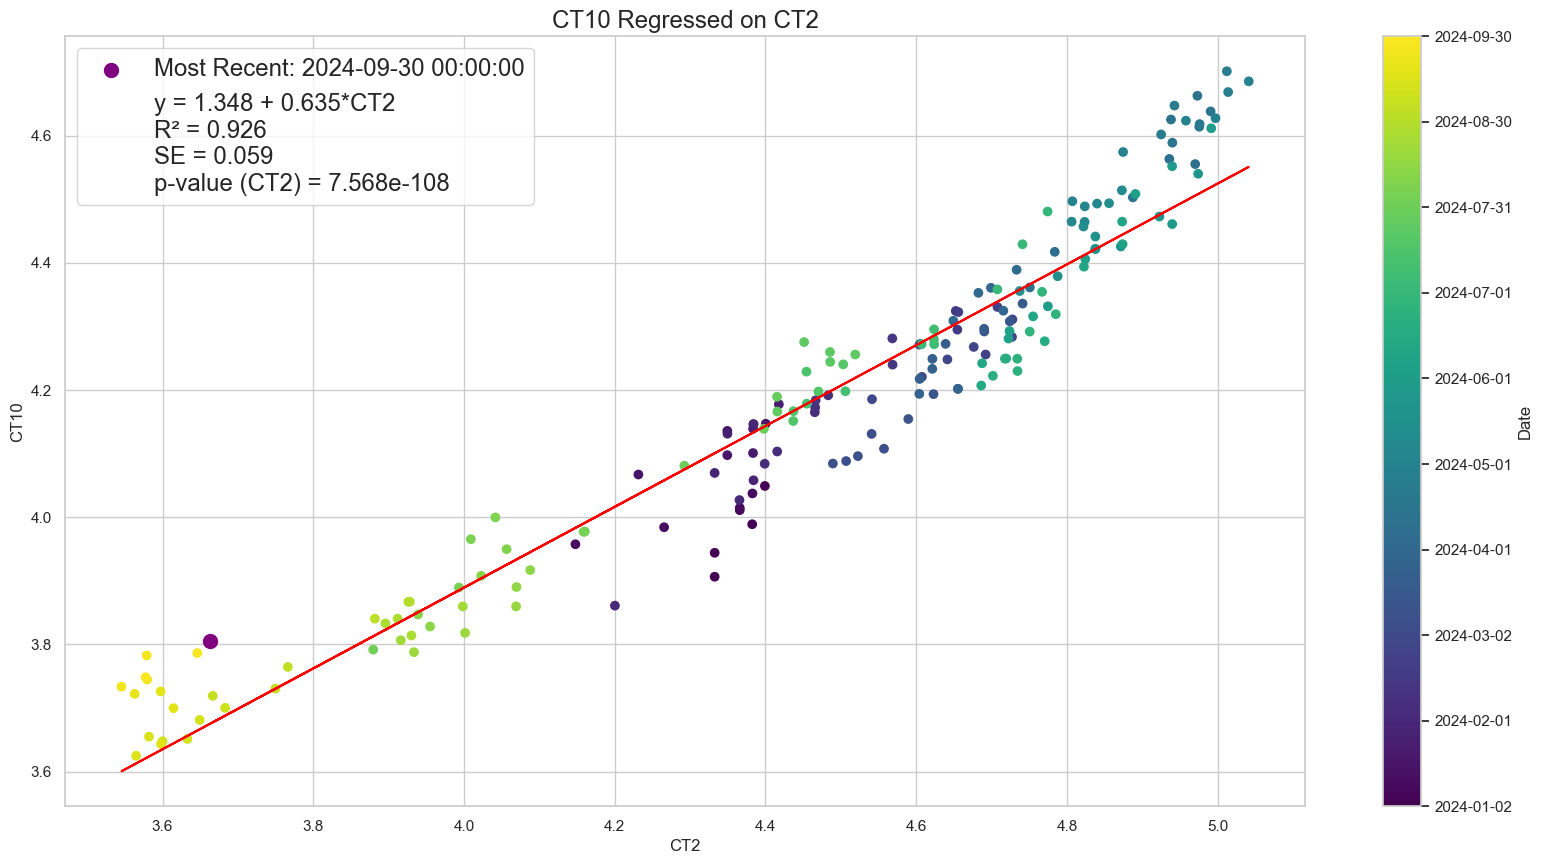

                            OLS Regression Results                            
Dep. Variable:      level_change_CT10   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     560.3
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           5.15e-58
Time:                        22:45:10   Log-Likelihood:                 357.22
No. Observations:                 188   AIC:                            -710.4
Df Residuals:                     186   BIC:                            -704.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0023      0.003  

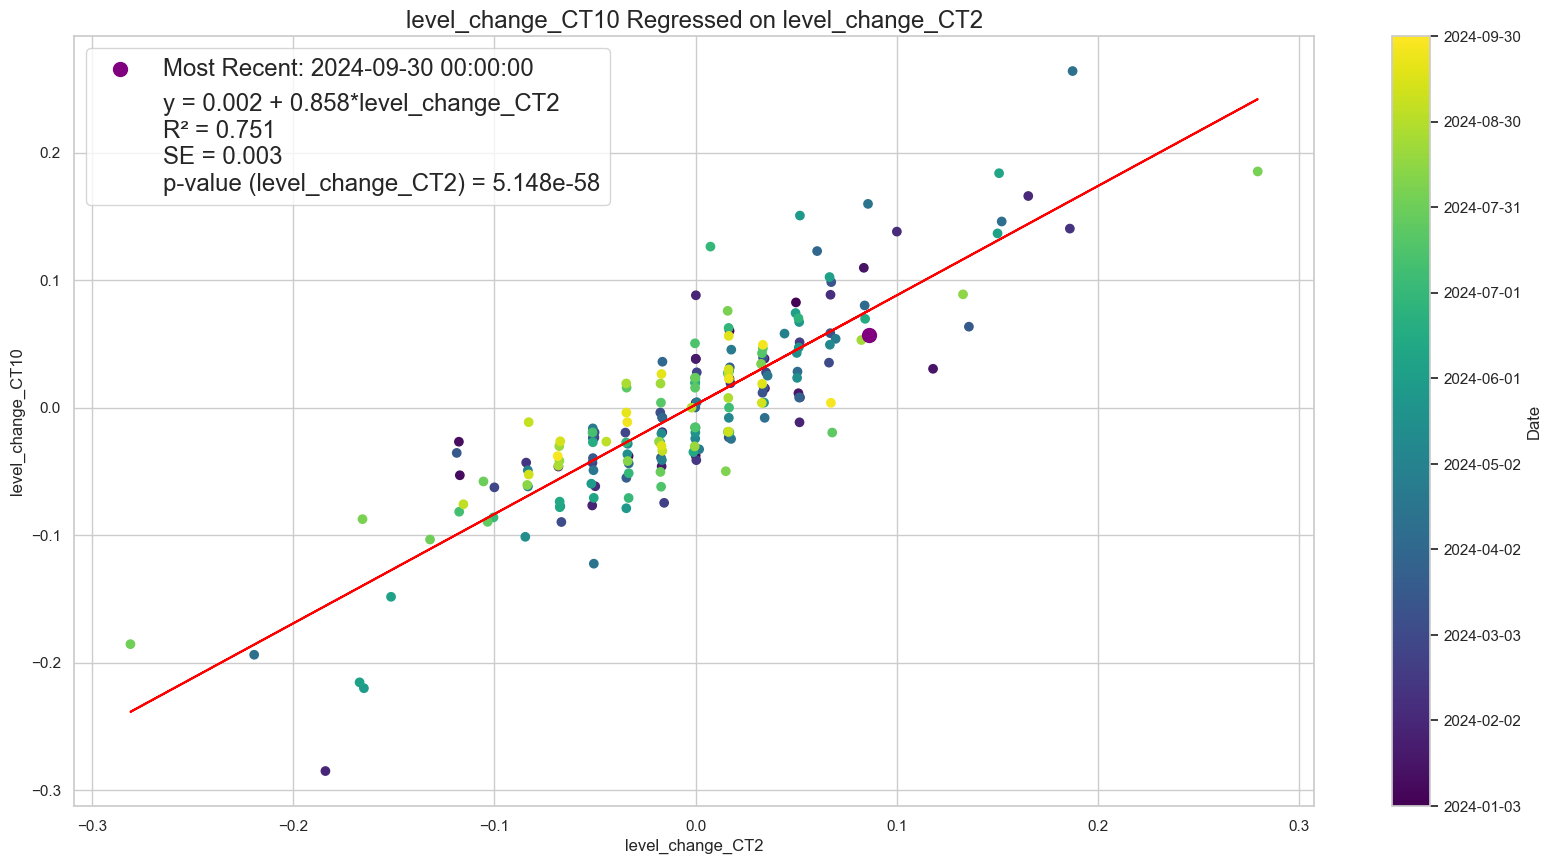

In [205]:
# hh = hedge_hog(
#     df=ct_yields_df,
#     # run_on_percent_changes=True,
#     run_on_level_changes=True,
#     x_cols=["CT2"],
#     y_col="CT10", 
#     # x_errs=x_errs_array, 
#     # y_errs=y_errs_array, 
#     run_pca_on_corr_mat=True
# )
# ols_results = hh["ols"]

df = ct_yields_df
date_col = df["Date"]
df = df[["CT2", "CT10"]].diff()
df.columns = ["level_change_CT2", "level_change_CT10"]
df["Date"] = date_col

# if run_on_percent_changes:
#     date_col = df["Date"]
#     df = df[x_cols + [y_col]].pct_change()
#     df["Date"] = date_col

run_basic_linear_regression_df(df=ct_yields_df, x_col="CT2", y_col="CT10", date_color_bar=True)
run_basic_linear_regression_df(df=df, x_col="level_change_CT2", y_col="level_change_CT10", date_color_bar=True)

## Visualization 3: Finding Relative Value

### Visualization 3-B: Mean Reversion  

## Conclusion:

## References and Further Reading: